# FGS1 signal EDA

## Notebooks set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


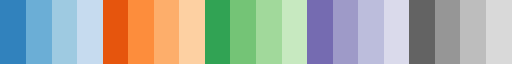

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Local imports
import configuration as config

# Create figures directory for saving plots
figures_dir = f'{config.FIGURES_DIRECTORY}/EDA'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

## 1. Single planet

In [2]:
# Define path to example FGS1 signal file
fgs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/FGS1_signal_0.parquet'
print(f'Example FGS1 signal file path: {fgs_file}')

Example FGS1 signal file path: ./data/raw/train/342072318/FGS1_signal_0.parquet


In [3]:
# Read the Parquet file and reshape into 3D array (frames, rows, cols)
frames = pd.read_parquet(fgs_file).to_numpy().reshape(135000, 32, 32)
print(f'Raw signal shape: {frames.shape}')
print(f'Raw frame shape: {frames[0].shape}')

Raw signal shape: (135000, 32, 32)
Raw frame shape: (32, 32)


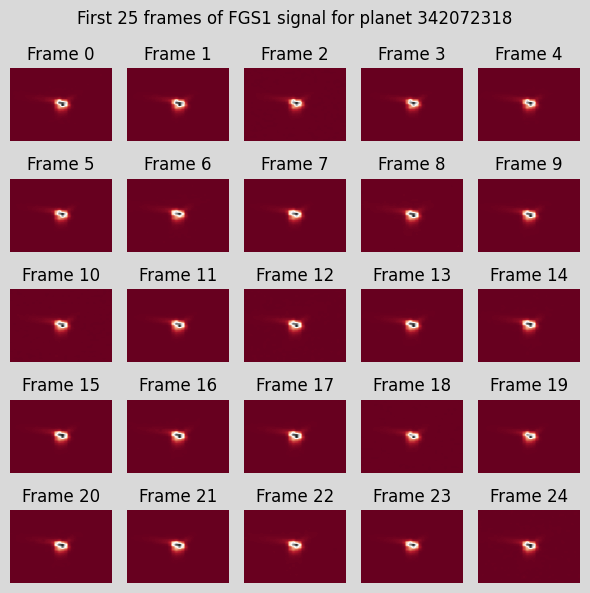

In [4]:
# Plot the first 25 frames in a 5x5 grid to visualize guidance camera data
n_frames = 25
n_dim = int(n_frames**0.5)
dim = n_dim * 2
fig, axs = plt.subplots(n_dim, n_dim, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)
axs = axs.flatten()

fig.suptitle(f'First {n_frames} frames of FGS1 signal for planet {config.SAMPLE_PLANET}')

for i in range(n_frames):

    frame = frames[i]
    
    # Normalize each frame by its mean for better visualization
    frame = frame.astype(float) / np.mean(frame.astype(float))

    axs[i].set_title(f'Frame {i}')
    axs[i].imshow(frame, aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
    axs[i].axis('off')  # Remove all axis elements for cleaner display

fig.tight_layout()

# Save the visualization
fig.savefig(
    f'{figures_dir}/01.4.1-FGS1_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, 
    bbox_inches='tight'
)

Yep - just what I thought. Narrow wavelength, but much smaller data & easy to crop even smaller. We can use the total brightness to see the transits. In fact, I bet they jump right out...

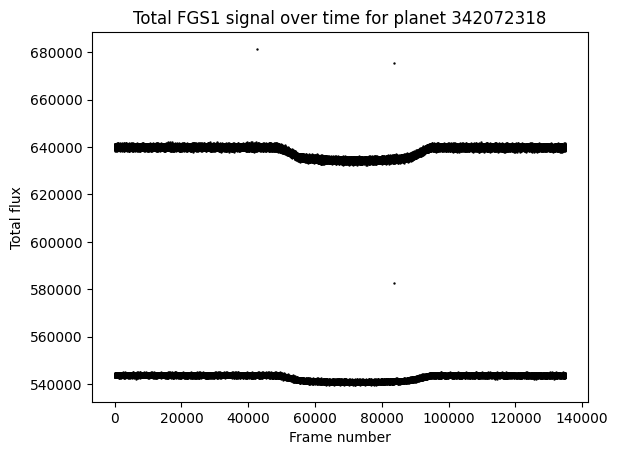

In [5]:
# Calculate total flux for each frame to detect transit signature
total_flux = [np.sum(frame) for frame in frames]

# Plot the raw transit lightcurve
plt.title(f'Total FGS1 signal over time for planet {config.SAMPLE_PLANET}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux')
plt.savefig(
    f'{figures_dir}/01.4.2-example_raw_transit.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

Bingo - definitely need some calibration, etc., but the transit is obvious. We can probably dump a lot of data too. I think the two traces are probably the alternating detector read thing mentioned in the section about the signal files on the [competition data page](https://www.kaggle.com/competitions/ariel-data-challenge-2025/data). We could probably just take the high signal trace. That by itself will cut the data in half. Then, since we are only interested in the spectrum of the planet we can take pieces of the time series. Maybe just the bottom of the well and one of the limbs. Use those parts of the time series for signal and background. Wow, this is a cool problem. One last thing before we call it a night - can we see the transit visually?

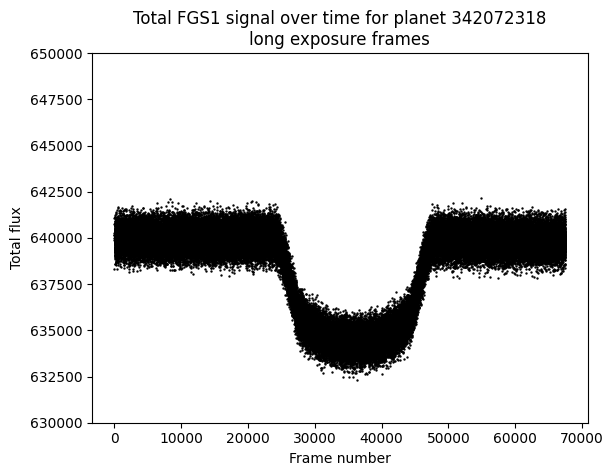

In [6]:
# Extract high signal trace by selecting every other frame (long exposures)
total_flux = [np.sum(frame) for frame in frames]
total_flux = total_flux[1:-1]  # Remove first and last frames
total_flux = total_flux[0::2]  # Select only high signal frames

# Plot the cleaned transit lightcurve
plt.title(f'Total FGS1 signal over time for planet {config.SAMPLE_PLANET}\nlong exposure frames')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux')
plt.ylim(630000, 650000)  # Zoom in to see transit details
plt.savefig(
    f'{figures_dir}/01.4.2-transit_high_trace.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

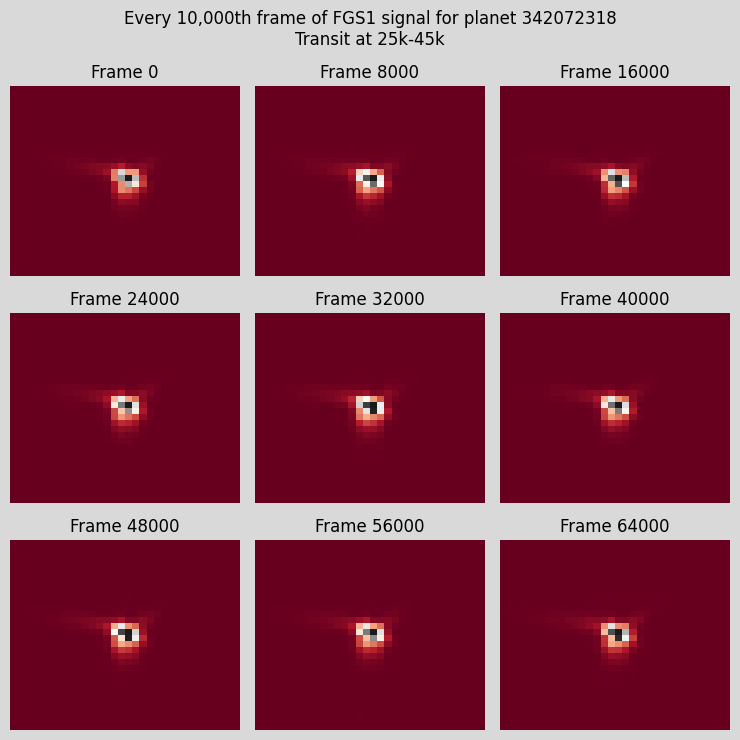

In [7]:
# Sample frames throughout the observation to look for visual transit signature
sampling_frequency = 8000
samples = frames[1:-1]  # Remove first and last frames
samples = samples[0::2]  # Select high signal frames
samples = samples[1::sampling_frequency]  # Sample every 8000th frame

# Display sampled frames in a 3x3 grid to show temporal evolution
n_frames = 9
n_dim = int(n_frames**0.5)
dim = n_dim * 2.5
fig, axs = plt.subplots(n_dim, n_dim, figsize=(dim, dim))
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)
axs = axs.flatten()

fig.suptitle(f'Every 10,000th frame of FGS1 signal for planet {config.SAMPLE_PLANET}\n' +
    'Transit at 25k-45k')

for i in list(range(n_frames)): 
    frame = samples[i]
 
    # Normalize frame for better visualization
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].set_title(f'Frame {i*sampling_frequency}')
    axs[i].imshow(frame, aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
    axs[i].axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/01.4.4-example_transit_frames.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

Nope, I cant see it. Oh, well - not a problem. Would have been cool, but we are talking about a tiny dip relative to the total signal - for this planet the reduction in total signal during the transit is ~1.2%.

I think the next thing to focus on is figuring out how to/if we can align the FGS1 and AIRS signals in time. The timeseries have different numbers of frames, but I think there is probably going to be some metadata we can use in the ancillary data files. Tomorrow.

In [8]:
# Save sample frames for unit testing
test_planet = f'{config.DATA_DIRECTORY}/raw/train/{config.SAMPLE_PLANET}'
Path(test_planet).mkdir(parents=True, exist_ok=True)

# Load original data and extract first N frames for testing
frames = pd.read_parquet(f'{test_planet}/FGS1_signal_0.parquet').to_numpy().reshape(135000, 32, 32)
test_frame = frames[:config.SAMPLE_FRAMES]
test_frame = test_frame.flatten()

# Create test data directory structure
test_planet = f'./tests/test_data/raw/train/{config.SAMPLE_PLANET}'
Path(test_planet).mkdir(parents=True, exist_ok=True)

# Save test frames as parquet file
with open(f'{test_planet}/FGS1_signal_0.parquet', 'wb') as output_file:
    pd.DataFrame(test_frame).to_parquet(output_file)